In [1]:
import tensorflow as tf
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class MinibatchDiscriminator(tf.keras.layers.Layer):
    def __init__(self, b, c):
        super(MinibatchDiscriminator, self).__init__()
        self.b = b
        self.c = c

    def build(self, input_shape):
        self.T = self.add_weight(
            shape=(input_shape[-1], self.b, self.c),
            initializer=tf.keras.initializers.Zeros(),
            trainable=True,
        )
    
    @tf.function
    def call(self, inputs):
        M = tf.tensordot(inputs, self.T, axes=[[1],[0]])
        diff = tf.expand_dims(M,0) - tf.expand_dims(M,1)
        c = tf.math.exp(-tf.norm(diff, ord=1, axis=3))
        o = tf.reduce_sum(c, axis=1)
        return tf.concat([inputs, o], 1)

     

In [3]:
a = tf.cast(tf.constant([[1,1],[2,2],[3,3],[4,4],[5,5]]), 'float')
ll = MinibatchDiscriminator(10,11)
out = ll(a)
print(out.shape)

(5, 12)


In [4]:
class AAE:
    def __init__(self, input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size):
        super(AAE, self).__init__()
        self.stride_reduction = 1
        for i, stride in enumerate(strides):
            self.stride_reduction = self.stride_reduction * stride
        self.latent_dim = latent_dim
        self.ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.ae_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        self.dc_accuracy = tf.keras.metrics.BinaryAccuracy()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            #tf.keras.layers.Conv2D(filters=filters[4], kernel_size=kernel_size[4], strides=strides[4], padding='same'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Flatten(),
            #tf.keras.layers.Dense(dense_units[0], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dense(dense_units[1], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dense(dense_units[2], activation='tanh'),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = tf.keras.Sequential([
            #tf.keras.layers.InputLayer(input_shape=latent_dim),
            #tf.keras.layers.Dense(dense_units[2], activation='tanh'),
            #tf.keras.layers.Dense(dense_units[1], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dense(dense_units[0], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(int(input_shape[0]*input_shape[1]*filters[3]/self.stride_reduction**2), activation='relu'),
            tf.keras.layers.Reshape((int(input_shape[0]/self.stride_reduction), int(input_shape[1]/self.stride_reduction), filters[3])),
            #tf.keras.layers.Conv2DTranspose(filters=filters[4], kernel_size=kernel_size[4], strides=strides[4], padding='same'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel_size[0], strides=1, padding='same'),
        ])

        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(discriminator_units[0], activation='relu'),
            tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dropout(keep_prob),
            #MinibatchDiscriminator(minidc_dims[0,0], minidc_dims[0,1]),
            tf.keras.layers.Dense(discriminator_units[1], activation='relu'),
            tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dropout(keep_prob),
            MinibatchDiscriminator(minidc_dims[1,0], minidc_dims[1,1]),
            #tf.keras.layers.Dense(discriminator_units[2], activation='relu'),
            #tf.keras.layers.Dropout(keep_prob),
            tf.keras.layers.Dense(1, activation='sigmoid'),
        ])
    
    def sample(self, n_samples, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    @tf.function
    def encode(self, x, training=False):
        mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
        return mean, log_var

    @tf.function
    def reparametrize(self, mean, log_var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * .5) + mean
    
    @tf.function
    def encode_and_reparametrize(self, x, training=False):
        mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
        return self.reparametrize(mean, log_var)

    @tf.function
    def decode(self, z, apply_sigmoid=False, training=False):
        logits = self.decoder(z, training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    @tf.function
    def autoencoder_loss(self, X, training=False):
        # Generate latent space vector by encoding X
        mean_generated, log_var_generated = self.encode(X, training=training)
        z_generated = self.reparametrize(mean_generated, log_var_generated)
        # Decode
        X_generated = self.decode(z_generated, apply_sigmoid=True, training=training)
        # Autoencoder loss
        ae_loss = tf.reduce_mean(tf.math.squared_difference(X_generated, X))
        #ae_loss = self.ae_cross_entropy(y_true=X, y_pred=X_generated)
        return ae_loss
    
    @tf.function
    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @tf.function
    def train_step(self, batch_x):
        # Autoencoder
        with tf.GradientTape() as ae_tape:
            # Autoencoder loss
            ae_loss = self.autoencoder_loss(batch_x, training=True)
    
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        generated_noise = tf.random.normal([batch_x.shape[0], self.latent_dim], mean=0.0, stddev=1.0)
        # Discriminator
        with tf.GradientTape() as dc_tape:
            encoder_output = self.encode_and_reparametrize(batch_x, training=False)
            dc_fake = self.discriminator(encoder_output, training=True)
            dc_real = self.discriminator(generated_noise, training=True)
            # Discriminator Loss
            dc_loss = self.discriminator_loss(dc_real, dc_fake)
            # Discriminator Acc
            dc_acc = self.dc_accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                        tf.concat([dc_real, dc_fake], axis=0))

        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))

        # Generator (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encode_and_reparametrize(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=False)
            # Generator loss
            gen_loss = self.generator_loss(dc_fake)

        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))

        return ae_loss, dc_loss, dc_acc, gen_loss
    
    def fit(self, train_dataset, epochs):
        self.encoder.compile()
        self.decoder.compile()
        self.discriminator.compile()
        ae_loss_history = []
        dc_loss_history = []
        gen_loss_history = []
        global_step = 0
        ae_loss = 0
        dc_loss = 0
        dc_acc = 0
        gen_loss = 0
        for epoch in range(epochs):
            if epoch in [40, 80, 120, 160, 200]:
                self.base_lr = self.base_lr / 2
                self.max_lr = self.max_lr / 2
                self.step_size = self.step_size / 2
            epoch_start = dt.now()
            for train_x in train_dataset:
            #    global_step = global_step + 1
            #    cycle = np.floor(1 + global_step / (2 * self.step_size))
            #    x_lr = np.abs(global_step / self.step_size - 2 * cycle + 1)
            #    clr = self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x_lr)
                self.ae_optimizer.learning_rate = base_lr
                self.dc_optimizer.learning_rate = base_lr
                self.gen_optimizer.learning_rate = base_lr
                ae_loss, dc_loss, dc_acc, gen_loss = self.train_step(train_x)
                ae_loss_history.append(ae_loss)
                dc_loss_history.append(dc_loss)
                gen_loss_history.append(gen_loss)
        
            epoch_end = dt.now()
            print("Epoch: {}, time elapsed: {}, AE loss: {}, Discriminator loss: {}, Discriminator accuracy: {}, Generator loss: {}".format(epoch + 1, epoch_end - epoch_start, ae_loss, dc_loss, dc_acc, gen_loss))
        
        return ae_loss_history, dc_loss_history, gen_loss_history


In [5]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

length = train_images.shape[1]
width = train_images.shape[2]
channels = train_images.shape[3]

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [6]:
minidc_dims=np.array([[30,30],[30,30]])

base_lr = 0.001
max_lr = 0.0025
step_size = 2 * np.ceil(train_images.shape[0] / batch_size)
epochs = 200

latent_dim = 96
alpha_leaky = 0.1
filters = [48,96,192,384]
kernel_size = [4,4,3,3]
strides = [2,2,2,2]
dense_units = [500,300]
discriminator_units = [100, 50]
keep_prob = 0.5

steps_per_epoch = train_images.shape[0] / batch_size

aae = AAE((length, width, channels), latent_dim, alpha_leaky, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size)
ae_loss_history, dc_loss_history, gen_loss_history = aae.fit(train_dataset, epochs=epochs)

Epoch: 1, time elapsed: 0:02:08.005390, AE loss: 0.016620315611362457, Discriminator loss: 1.626523494720459, Discriminator accuracy: 0.5, Generator loss: 0.3132617175579071
Epoch: 2, time elapsed: 0:02:05.485628, AE loss: 0.0124745424836874, Discriminator loss: 1.626523494720459, Discriminator accuracy: 0.5, Generator loss: 0.3132617175579071
Epoch: 3, time elapsed: 0:02:07.997913, AE loss: 0.011791148222982883, Discriminator loss: 1.626523494720459, Discriminator accuracy: 0.5, Generator loss: 0.3132617175579071
Epoch: 4, time elapsed: 0:02:26.812292, AE loss: 0.008844857104122639, Discriminator loss: 1.626523494720459, Discriminator accuracy: 0.5, Generator loss: 0.3132617175579071
Epoch: 5, time elapsed: 0:02:39.879870, AE loss: 0.00999931339174509, Discriminator loss: 1.626523494720459, Discriminator accuracy: 0.5, Generator loss: 0.3132617175579071
Epoch: 6, time elapsed: 0:02:36.176113, AE loss: 0.008582391776144505, Discriminator loss: 1.626523494720459, Discriminator accuracy:

Text(0, 0.5, 'BinCE')

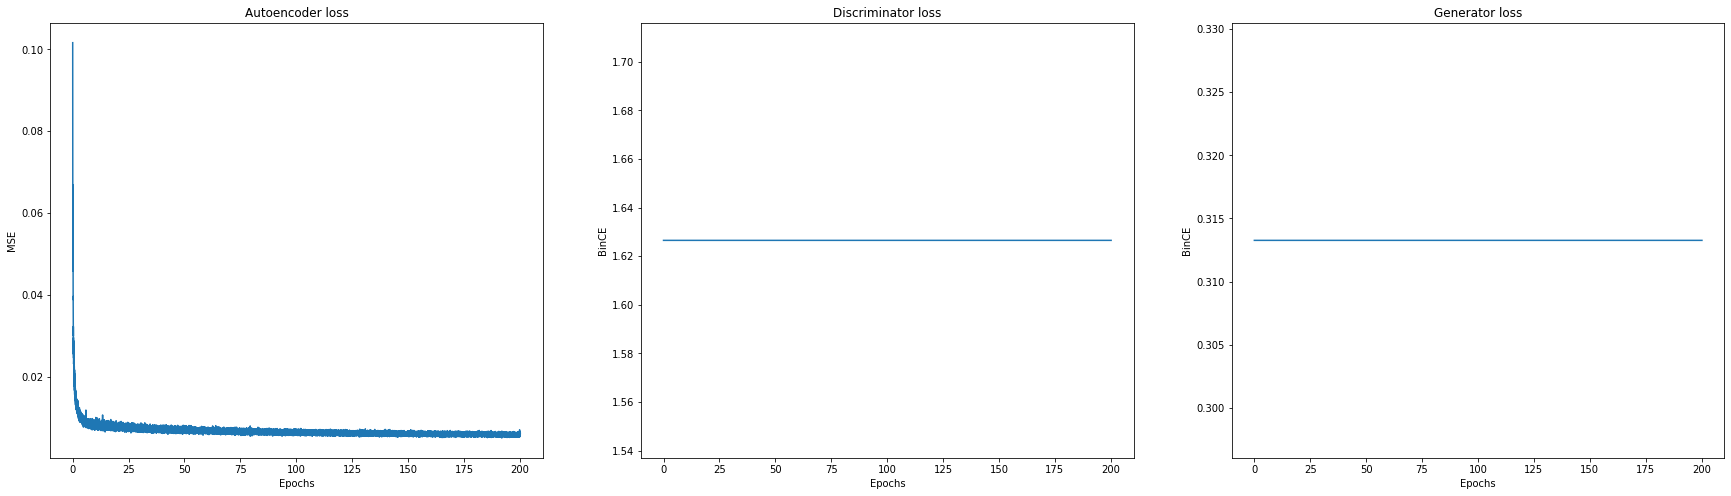

In [7]:
steps_per_epoch = train_images.shape[0] / batch_size

F, ax = plt.subplots(1,3,figsize=(30,8))
ax[0].plot((np.arange(len(ae_loss_history))+1)/steps_per_epoch, ae_loss_history)
ax[0].set_title('Autoencoder loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MSE')
ax[1].plot((np.arange(len(dc_loss_history))+1)/steps_per_epoch, dc_loss_history)
ax[1].set_title('Discriminator loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('BinCE')
ax[2].plot((np.arange(len(gen_loss_history))+1)/steps_per_epoch, gen_loss_history)
ax[2].set_title('Generator loss')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('BinCE')


In [8]:
aae.encoder.save('enc_model')
aae.decoder.save('dec_model')
aae.discriminator.save('dc_model')

INFO:tensorflow:Assets written to: enc_model\assets
INFO:tensorflow:Assets written to: dec_model\assets


AttributeError: 'NoneType' object has no attribute 'replace'

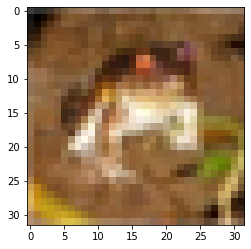

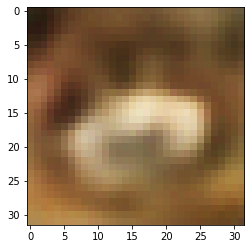

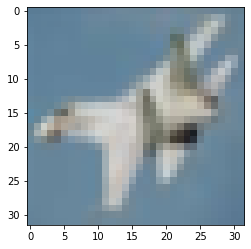

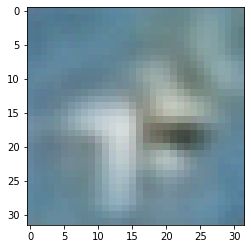

In [ ]:
image = train_images[0,:,:,:].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()

image = test_images[10,:,:,:].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()


In [ ]:
# Faccio il test error per batch perché sul mio PC la GPU va OOM
test_errors = []
for x_batch in test_dataset:
    test_err = aae.autoencoder_loss(x_batch)
    test_errors.append(test_err)
test_err = np.mean(test_errors)
print(test_err)

0.007493007


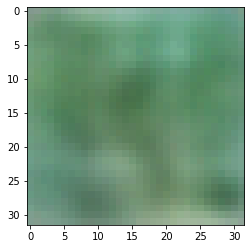

tf.Tensor([[0.9757481]], shape=(1, 1), dtype=float32)


In [ ]:
import tensorflow_probability as tfp

z = np.random.randn(1,latent_dim)
image = aae.decode(z, apply_sigmoid=True).numpy()
image = image * 255.
image=image.astype('int16')
image.reshape((32,32,3))
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
print(aae.discriminator(z))

In [ ]:
X = train_images[128].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(X)
print(z)
vote = aae.discriminator(z)
print(vote)

tf.Tensor(
[[-3.3145220e+00  4.2065630e+00  3.4170139e+00  5.3013773e+00
   2.1761572e+00  8.1925744e-01  1.5897872e+00  8.3335314e+00
  -7.2668886e+00 -6.5448936e-03  6.3023133e+00 -5.4112048e+00
   7.8379450e+00 -7.2685719e+00  3.5660255e+00 -2.1441568e-01
   6.0042343e+00  7.3950225e-01 -6.4591341e+00 -1.2005768e+00
  -2.6228433e+00  4.2494226e+00  5.1909432e+00  1.1251446e+00
  -1.6602622e+00 -7.7713948e-01  5.3321261e+00  2.0085542e+00
  -1.0324863e+00 -6.5298176e+00 -3.0567033e+00 -2.9142795e+00
  -8.0673856e-01  1.8370160e+00  3.4429657e+00  4.4338169e+00
   2.5479519e+00 -3.9061000e+00  4.6919328e-01  1.3318847e+00
  -9.3391687e-01 -6.2307304e-01  4.0893860e+00 -2.1663284e+00
   3.2280462e+00 -4.7679350e-01 -4.6370883e+00 -1.9773535e-01
   1.6837031e+00 -1.8354052e-01 -3.6703489e+00 -1.5132273e+00
  -4.6899366e+00  7.9172671e-01  1.0081598e+00  1.3936219e-01
  -2.0494940e+00 -3.6561579e-01 -3.7887743e+00  6.0169183e-02
   1.1330950e+00 -1.7752221e+00  2.1149259e+00 -5.2488699e+

In [ ]:
import tensorflow as tf
a = 2
b = 3
c = 4
f_x = tf.constant([[1,1],[2,2],[3,3],[4,4],[5,5]])
print(f_x.shape)
T = tf.constant([[[1,1,1,1],[2,2,2,2],[3,3,3,3]],[[4,4,4,4],[5,5,5,5],[6,6,6,6]]])
print(T.shape)
M = tf.tensordot(f_x, T, axes=[[1],[0]])
print(M.shape)
diff = tf.expand_dims(M, 0) - tf.expand_dims(M,1)
print(diff.shape)
c = tf.norm(diff, ord=1, axis=3)
c = tf.cast(c, 'float')
c = tf.math.exp(-c)
print(c.shape)
o = tf.reduce_sum(c, axis=1)
print(o.shape)



(5, 2)
(2, 3, 4)
(5, 3, 4)
(5, 5, 3, 4)
(5, 5, 3)
(5, 3)
